# Evalute model performance

We can calculate the distance between labeled coordinates and the coordinates extracted from the model predicted segmentation masks.


In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import cv2
import os
import pickle

from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask

Get project and datasets to get some predictions from the model.

In [2]:
project = TrackingProject(name="mouseTrack",root_folder = "/home/kevin/Documents/trackingProjects/")

Project directory: /home/kevin/Documents/trackingProjects/mouseTrack
Loading /home/kevin/Documents/trackingProjects/mouseTrack/config.yalm
{'augmentation_HorizontalFlipProb': 0.0, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_size': [480, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'mouseTrack', 'normalization_values': {'means': [0.3958178758621216, 0.39585205912590027, 0.39564093947410583], 'stds': [0.11448581516742706, 0.11446335166692734, 0.11462123692035675]}, 'object_colors': [(0.0, 0.0, 255.0), (255.0, 0.0, 0.0), (255.0, 255.0, 0.0), (240.0, 255.0, 255.0)], 'objects': ['snout', 'earL', 'earR', 'tail'], 'target_radius': 5}


In [3]:
TRAIN_IMAGE_DIR = os.path.join(project.dataset_dir,"train_images")
TRAIN_MASK_DIR =  os.path.join(project.dataset_dir,"train_masks")
TRAIN_COORDINATE_DIR = os.path.join(project.dataset_dir,"train_coordinates")
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")



DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")) 
BATCH_SIZE = 2
NUM_WORKERS = 2
PIN_MEMORY=False

In [4]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /home/kevin/Documents/trackingProjects/mouseTrack/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.3958178758621216, 0.39585205912590027, 0.39564093947410583], std=[0.11448581516742706, 0.11446335166692734, 0.11462123692035675], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [5]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform) 
trainDataset = UNetDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR,TRAIN_COORDINATE_DIR, transform=valTransform) # use same transform as for val
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

valLoader = DataLoader(valDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)
trainLoader = DataLoader(trainDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)

In [6]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

Let's get an item from the validation dataset

In [7]:
imageIndex=1
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

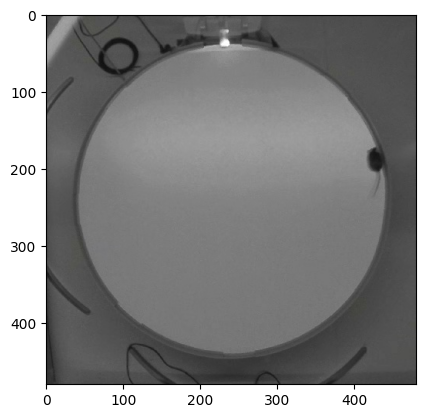

In [8]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [9]:
cDetector = CoordinatesFromSegmentationMask()

In [10]:
def check_accuracy(model,loader,device):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    num_mask = 0
    num_mask_detected = 0
    num_detected = 0
    sum_distance = 0

    model.eval()
    with torch.no_grad():
        for x,y,c in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = torch.sigmoid(model(x))
            preds = (output > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds * y).sum() / ((preds+y).sum() + 1e-8)) # work only for binary

            # proportion of the mask detected
            num_mask += y.sum()
            num_mask_detected += preds[y==1.0].sum()
            num_detected += preds.sum()

            # distance between predicted coordinates and labelled coordinates
            output = output.detach().cpu().numpy()
            pred_coords = cDetector.detect(output)

            sum_distance+= np.nanmean(np.sqrt(((pred_coords[:,:,0:2] - c.numpy())**2).sum(axis=2)))
            # we acutally do a mean of the error for the different objects in a batch


    print(f"Accuracy: {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader):.2f}")
    print(f"Mask pixels detected: {num_mask_detected/num_mask*100:.2f}%")
    print(f"False positives: {(num_detected-num_mask_detected)/num_detected*100:.2f}%")
    print(f"Mean error (distance in pixels): {sum_distance/len(loader)}")
    a = model.train()     

In [13]:
check_accuracy(model,valLoader,DEVICE)

Accuracy: 99.98
Dice score: 0.61
Mask pixels detected: 53.11%
False positives: 21.89%
Mean error (distance in pixels): 2.3375923092093913


In [14]:
check_accuracy(model,trainLoader,DEVICE)

Accuracy: 99.99
Dice score: 0.76
Mask pixels detected: 66.35%
False positives: 9.51%
Mean error (distance in pixels): 1.0425167821689418
